In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))
from common_util import setup_axis_default,kbar_gl,kbar_jmak,tbar,hdi, markdown_table_from_df

import warnings

### Time-to Recrystillization

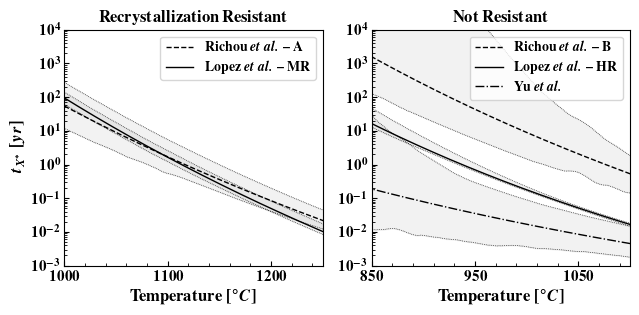

In [9]:
import jax.numpy as jnp
from numpyro.distributions import Normal
from numpyro.diagnostics import hpdi
from jax import vmap
from jax import random
rng_key = random.PRNGKey(136)
from scipy.signal import savgol_filter  
from scipy.optimize import bisect
from typing import Callable, Tuple
from numpy.polynomial import Polynomial
import math

SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR

def sample_jmak_model_time(X: float,
                            T: jnp.ndarray,
                            a1: jnp.ndarray,
                            a2: jnp.ndarray,
                            B1: jnp.ndarray,
                            B2: jnp.ndarray,
                            n: jnp.ndarray,
                            sigma: jnp.ndarray = None) -> np.ndarray:
    
    error = 0.0 if sigma is None else Normal(0,sigma).sample(random.PRNGKey(B1.astype(int)))
    X_ = X - error
    Y = jnp.where(X_ <= 1e-4, 1e-4, X_)
    Z = jnp.where(Y > 1 - 1e-4, 1 - 1e-4, Y)

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    return 1.0/b*jnp.log(1./(1. - Z))**(1/n) + t_inc  

def sample_glm_time(X: float,
                           T: jnp.ndarray,
                           a1: jnp.ndarray,
                           a2: jnp.ndarray,
                           B1: jnp.ndarray,
                           B2: jnp.ndarray,
                           nu: jnp.ndarray,
                           sigma: jnp.ndarray = None) -> np.ndarray:
    
    error = 0.0 if sigma is None else Normal(0,sigma).sample(random.PRNGKey(B1.astype(int)))
    X_ = X - error
    Y = jnp.where(X_ <= 1e-4, 1e-4, X_)
    Z = jnp.where(Y > 1 - 1e-4, 1 - 1e-4, Y)

    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)
    return M - 1/B*jnp.log(Z**(-nu) - 1)

def vmapped_sample_model_time(model_time: Callable,
                                X: float,
                                   T: jnp.ndarray,
                                   a1: jnp.ndarray,
                                   a2: jnp.ndarray,
                                   B1: jnp.ndarray,
                                   B2: jnp.ndarray,
                                   n: jnp.ndarray,
                                   sigma: jnp.ndarray = None,
                                   ) -> np.ndarray:
    
    def single_temperature(T_: jnp.ndarray) -> np.ndarray:
        return vmap(model_time,in_axes = (None,None,0,0,0,0,0,0))(X,T_,a1,a2,B1,B2,n,sigma)

    return vmap(single_temperature,in_axes = (0))(T)

def sample_jmak_model(t: jnp.ndarray,
                        T: jnp.ndarray,
                        a1: jnp.ndarray,
                        a2: jnp.ndarray,
                        B1: jnp.ndarray,
                        B2: jnp.ndarray,
                        n: jnp.ndarray,
                        sigma: jnp.ndarray = None) -> np.ndarray:

    error = 0.0 if sigma is None else Normal(0,sigma).sample(random.PRNGKey(B1.astype(int)))
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    t_eff = t - t_inc
    t_eff[t_eff < 0.] = 0.0   

    X_ =  1. - np.exp(-(b**n*t_eff**n)) + error
    Y = jnp.where(X_ < 0.0, 0.0, X_)
    Z = jnp.where(Y > 1.0, 1.0, Y)
    return Z
    
def plot_jmak_ttr(ax: plt.Axes,
                  data_name: str,
                  T: np.ndarray,
                  X: float,
                  ls = '-',
                  label = None,
                  color = 'k',
                  alpha = 0.95):

    model_name = 'JMAK_{}'
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_samples.pkl'),'rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f))

    inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_params.csv'),index_col = 0)
    ml_est = inf_summary.loc[['a1','a2','B1','B2','n'],'ml'].to_numpy()
    samples = [jnp.array(samples[p].values) for p in ['a1','a2','B1','B2','n','sigma']]

    t = vmapped_sample_model_time(sample_jmak_model_time,X,jnp.array(T),*samples)
    lower,upper = hpdi(t.T,alpha)
    t_ml = sample_jmak_model_time(X,jnp.array(T),*ml_est)
    
    plot_ttr(ax,T,t_ml,lower,upper,label,color,ls)

def plot_glm_ttr(ax: plt.Axes,
                    data_name: str,
                    T: np.ndarray,
                    X: float,
                    ls = '-',
                    label = None,
                    color = 'k',
                    alpha = 0.95):
    
    model_name = 'Generalized Logistic_{}'
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_samples.pkl'),'rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f))
    
    inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_params.csv'),index_col = 0)
    ml_est = inf_summary.loc[['a1','a2','B1','B2','nu'],'ml'].to_numpy()
    samples = [jnp.array(samples[p].values) for p in ['a1','a2','B1','B2','nu','sigma']]
    t = vmapped_sample_model_time(sample_glm_time,X,jnp.array(T),*samples)
    lower,upper = hpdi(t.T,alpha)
    t_ml = sample_glm_time(X,jnp.array(T),*ml_est)

    plot_ttr(ax,T,t_ml,lower,upper,label,color,ls)


def plot_ttr(ax: plt.Axes,
             T: np.ndarray,
             t_ml: np.ndarray,
             lower: np.ndarray,
             upper: np.ndarray,
             label: str,
             color: str,
             ls: str): 

    setup_axis_default(ax)
    ax.set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)
    ax.set_ylabel(r'\textbf{$t_{X^*}$ [$yr$]}',fontsize = 12)

    fci = []
    for ci in [lower,upper]:
        fci.append(savgol_filter(ci,101,2))
        ax.plot(T-273.15,fci[-1]/SECONDS_TO_YEAR,color = 'k',lw = 0.5,ls = ':')

    ax.plot(T-273.15,t_ml/SECONDS_TO_YEAR,label = label,color = color,linestyle = ls,lw = 1.0)
    ax.fill_between(T-273.15,fci[0]/SECONDS_TO_YEAR,fci[1]/SECONDS_TO_YEAR,alpha = 0.1,color = 'grey')

fig,axes = plt.subplots(ncols = 2,figsize = (6.5,3.25))

X = 0.9
labels = [[r'\textbf{Richou \textit{et al.} -- A}',r'\textbf{Lopez \textit{et al.} -- MR}'],
          [r'\textbf{Richou \textit{et al.} -- B}',r'\textbf{Lopez \textit{et al.} -- HR}',r'\textbf{Yu \textit{et al.}}']]

data_labels = [['Richou et al. (2020) - Batch A','Lopez et al. (2015) - MR'],
               ['Richou et al. (2020) - Batch B','Lopez et al. (2015) - HR','Yu et al. (2017)']]

linestyles = ['--','-','-.']
temperatures = [np.linspace(950,1300,1000) + 273.15,
                np.linspace(800,1150,1000) + 273.15]
titles = [r'\textbf{Recrystallization Resistant}',r'\textbf{Not Resistant}']
xticks = [np.arange(1000,1300,100),np.arange(850,1200,100)]
xlims = [(1000,1250),(850,1100)]
for ax,data_names,dlabels,T,title,xtick,xlim in zip(axes,data_labels,labels,temperatures,titles,xticks,xlims):
    for data_name,ls,label in zip(data_names,linestyles,dlabels):
        plot_jmak_ttr(ax,data_name,T,X,ls = ls,label = label)

    ax.set_title(title,fontsize = 12)   
    ax.legend(loc = 'upper right',fontsize = 10)
    ax.set_yscale('log')
    ax.set_ylim([1e-3,1e3])
    ax.set_yticks(np.logspace(-3,4,8))
    ax.set_xticks(xtick)
    ax.set_xlim(xlim)

axes[1].set_ylabel('')
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('jmak_ttr.svg'),bbox_inches = 'tight')

### Estimate Temperature at Time-to-Recrystillization ($X = X^*$) at 1 Year

In [5]:
def get_temperature(time_function: Callable,
                    t: float,
                    T_bounds: Tuple = (873.15,2273.15)) -> np.ndarray:
    
    def _search_function(T: float) -> float:
        return time_function(T) - t

    return bisect(_search_function,*T_bounds)

def estimate_temperature_from_samples(model_time: Callable,
                                      at_time: float,
                                      T_bounds: jnp.ndarray,
                                      X: float,
                                      samples: jnp.ndarray,
                                      ml_est: jnp.ndarray,
                                      n_points: int = 20,
                                      alpha = 0.95,
                                      order: int = 3) -> np.ndarray:
    
    class TemperatureBoundEstimator:

        def __init__(self,temperature: np.ndarray,
                            time: np.ndarray):
            
            self.time = time
            self.temperature = temperature
            self.poly = Polynomial.fit(temperature,np.log(time),order)  
    
        def __call__(self,T: float) -> float:
            return math.exp(self.poly(T))

    T = jnp.linspace(*T_bounds,n_points)
    t_sample = vmapped_sample_model_time(model_time,X,T,*samples)
    lower,upper = [TemperatureBoundEstimator(T,ci) for ci in hpdi(t_sample.T,alpha)]

    def ml_estimator(T: float) -> float:
        return model_time(X,T,*ml_est)
    
    pe = []
    for est_func in [ml_estimator,lower,upper]:
        try:
            pe.append(get_temperature(est_func,at_time,T_bounds = T_bounds))
        except ValueError:
            pe.append(np.nan)
    
    return np.array(pe) 

def make_table(df: pd.DataFrame,
               title: str,
               caption: str,
               replace_nan: str = 'N/A') -> str:
    
    title_caption = '**' + title + '**:' + caption + '\n'
    table_str = np.round(df).to_markdown()
    if replace_nan is not None:
        table_str = table_str.replace('nan',replace_nan)

    return title_caption + table_str + '\n'
    


model_name = 'Generalized Logistic_{}'
model_time = sample_glm_time if 'Generalized Logistic' in model_name else sample_jmak_model_time    
ep_param = 'nu' if 'Generalized Logistic' in model_name else 'n'
model_params = ['a1','a2','B1','B2',ep_param,'sigma']

data_labels = ['Richou et al. (2020) - Batch A','Lopez et al. (2015) - MR',
               'Richou et al. (2020) - Batch B','Lopez et al. (2015) - HR','Yu et al. (2017)']

t_ranges = [(1000,1200),(1000,1200),(990,1150),(900,1100),(800,1000)]

X = 0.1
point_estimates = []
for data_name,trange in zip(data_labels,t_ranges):
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_samples.pkl'),'rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f))

    samples = [jnp.array(samples[p].values) for p in model_params]

    inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_params.csv'),index_col = 0)
    ml_est = inf_summary.loc[model_params[:-1],'ml'].to_numpy()
    point_est = estimate_temperature_from_samples(model_time,
                                              SECONDS_TO_YEAR,
                                              (trange[0] + 273.15,trange[1] + 273.15),
                                              X,
                                              samples,
                                              ml_est,
                                              alpha = 0.95,
                                              n_points = 200)
    point_estimates.append(point_est.copy())

point_estimates = pd.DataFrame(np.array(point_estimates) - 273.15,
                               index = data_labels,
                               columns = ['ML',r'Lower 95\%',r'Upper 95%'])

with open(GIT_TABLE_PATH.joinpath(f'X_{X}_{model_name.format("temperature_estimates")}.tbl'),'w') as f:
    f.write(
        make_table(point_estimates,
                    title = model_name[:-3] + ' ' + r'1-year Recrystillization Temperature [$^\circ C$]',
                    caption = rf'The temperature required to achieve a recrystillization fraction of ${X}$ after $1$ year.')
    )

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_64244\1923926354.py:27: RuntimeWarning: invalid value encountered in log
  self.poly = Polynomial.fit(temperature,np.log(time),order)
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_64244\1923926354.py:27: RuntimeWarning: invalid value encountered in log
  self.poly = Polynomial.fit(temperature,np.log(time),order)


### Parametric Time to Recrystillization

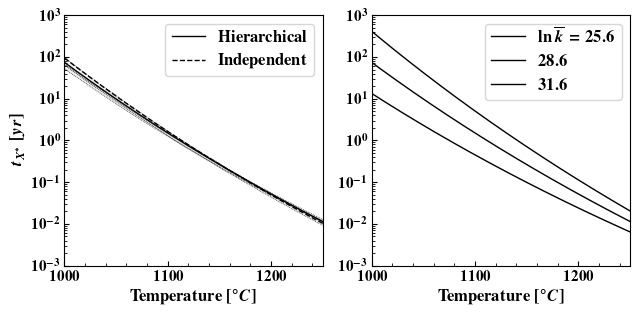

In [16]:
def sample_hierarchical_jmak_model_time(X: float,
                                    T: jnp.ndarray,
                                    a1c: jnp.ndarray,
                                    a2c: jnp.ndarray,
                                    B1c: jnp.ndarray,
                                    B2c: jnp.ndarray,
                                    nc: jnp.ndarray,
                                    latent_variables: jnp.ndarray,
                                    sigma: jnp.ndarray = None) -> jnp.ndarray:
    

    error = 0.0 if sigma is None else Normal(0,sigma).sample(rng_key)
    X_ = X - error
    Y = jnp.where(X_ < 0.0, 0.0, X_)
    Z = jnp.where(Y > 1.0, 1.0, Y)

    a1 = a1c[0] + a1c[1]*latent_variables[0]
    a2 = a2c[0] + a2c[1]*latent_variables[1]
    B1 = B1c[0] + B1c[1]*latent_variables[0]
    B2 = B2c[0] + B2c[1]*latent_variables[1]
    n = nc[0] + nc[1]*latent_variables[0]

    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)
    return 1.0/b*jnp.log(1./(1. - Z))**(1/n) + t_inc

def vmapped_sample_hierarchical_model_time(hierarchical_model_time: Callable,
                                X: float,
                                   T: jnp.ndarray,
                                   a1: jnp.ndarray,
                                   a2: jnp.ndarray,
                                   B1: jnp.ndarray,
                                   B2: jnp.ndarray,
                                   n: jnp.ndarray,
                                   latent_variables: jnp.ndarray,
                                   sigma: jnp.ndarray = None,
                                   ) -> np.ndarray:
    
    def single_temperature(T_: jnp.ndarray) -> np.ndarray:
        return vmap(hierarchical_model_time,in_axes = (None,None,0,0,0,0,0,0,0))(X,T_,a1,a2,B1,B2,n,latent_variables,sigma)

    return vmap(single_temperature,in_axes = (0))(T)

model_name = 'JMAK_{}'
with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_samples.pkl'),'rb') as f:
    samples = pickle.load(f)

data_index = 1

samples = [samples[p] for p in ['a1','a2','B1','B2','n','latent_variables','sigma']]
samples[-2] = samples[-2][:,data_index,:]
samples[-1] = samples[-1][:,data_index]

X = 0.9
t = vmapped_sample_hierarchical_model_time(sample_hierarchical_jmak_model_time,X,jnp.array(T),*samples).squeeze()
lower,upper = hpdi(t.T,0.95)

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_params.pkl'),'rb') as f:
    inf_summary = pickle.load(f)

T = np.linspace(950,1300,1000) + 273.15
titles = [r'\textbf{Recrystallization Resistant}',r'\textbf{Not Resistant}']
xticks = np.arange(1000,1300,100)

ml_est = [inf_summary['ml'][p] for p in ['a1','a2','B1','B2','n']]
ml_est.append(inf_summary['ml']['latent_variables'][data_index])
t_ml = sample_hierarchical_jmak_model_time(X,jnp.array(T),*ml_est).squeeze()
fig,axes = plt.subplots(ncols = 2,figsize = (6.5,3.25))

plot_ttr(axes[0],T,t_ml,lower,upper,r'\textbf{Hierarchical}',color = 'k',ls = '-')
plot_jmak_ttr(axes[0],'Lopez et al. (2015) - MR',T,X,ls = '--',label = r'\textbf{Independent}',color = 'k',alpha = 0.95)

t_param = ml_est[-1][1]
k_param = [float(ml_est[-1][0]) + off for off in [-3,0,3]]

setup_axis_default(axes[1])
axes[1].set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)

for i,kp in enumerate(k_param):
    ml_est[-1] = jnp.array([kp,t_param])
    t_ml = sample_hierarchical_jmak_model_time(X,jnp.array(T),*ml_est).squeeze()
    label = r'$\ln{\overline{k}} = ' + f'{round(kp,1)}' + r'$' if i == 0 else f'${round(kp,1)}$'

    axes[1].plot(T-273.15,t_ml/SECONDS_TO_YEAR,label = label,color = 'k',linestyle = '-',lw = 1.0)

axes[0].legend(fontsize = 12)
for ax in axes:
    ax.set_ylim([1e-3,1e3])
    ax.set_yticks(np.logspace(-3,3,7))
    ax.set_xticks(xticks)
    ax.set_xlim((1000,1250))
    ax.set_yscale('log')    

axes[1].legend(fontsize = 12)
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('hierarchical_parametric_ttr.svg'),bbox_inches = 'tight')


### Parametric Recrystillization Fraction

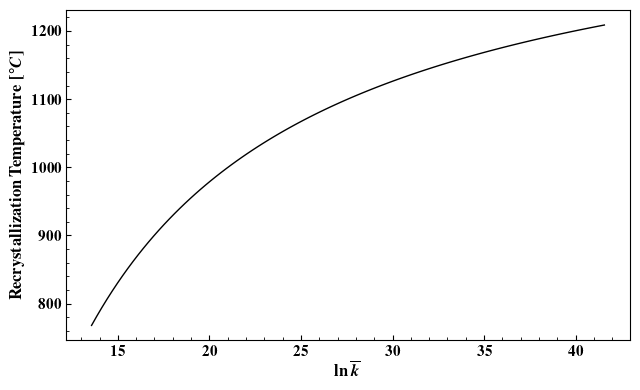

In [21]:
def estimate_hierarchical_model_temperature(model_time: Callable,
                                            at_time: float,
                                            T_bounds: jnp.ndarray,
                                            X: float,
                                            ml_est: jnp.ndarray) -> np.ndarray:

    def temp_func(T: float) -> float:
        return model_time(X,T,*ml_est)
    
    return get_temperature(temp_func,at_time,T_bounds = T_bounds)

ml_est = [inf_summary['ml'][p] for p in ['a1','a2','B1','B2','n']]
ml_est.append(inf_summary['ml']['latent_variables'][data_index])
t_ml = sample_hierarchical_jmak_model_time(X,jnp.array(T),*ml_est).squeeze()

t_param = ml_est[-1][1]
k_param = np.linspace(-15,13,100) + ml_est[-1][0]
temperatures= np.empty_like(k_param)
for i,kp in enumerate(k_param):
    ml_est[-1] = jnp.array([kp,t_param])
    temperatures[i] = estimate_hierarchical_model_temperature(sample_hierarchical_jmak_model_time,
                                                              SECONDS_TO_YEAR,
                                                              (600 + 273.15,1500 + 273.15),
                                                              X,
                                                              ml_est)


fig,ax = plt.subplots(figsize = (6.5,4.0))
setup_axis_default(ax)
ax.plot(k_param,temperatures - 273.15,color = 'k',lw = 1.0)

ax.set_xlabel(r'$\ln{\overline{k}}$',fontsize = 12)
ax.set_ylabel(r'\textbf{Recrystallization Temperature [$^\circ C$]}',fontsize = 12)
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('hierarchical_parametric_temperature_estimates.svg'),bbox_inches = 'tight')
